# Mantenimiento Predictivo Basado en Datos de Equipamiento de Microsoft Azure

## Resumen

El objetivo es construir un modelo de ML para predecir cuando habrá un fallo en los equipos, apoyandose en datos de telemetria y reportes de fallos, errores y mantenimientos. Pero para predecir los posibles fallos, uno debe saber que falla, cuanto tiempo resiste, que valores son los influyentes y más. Por tanto, para analizar el comportamiento tanto de los equipos como del modelo generado y comprender la situación, se requiere conocer el proposito de las distintas variables y la relacion que tienen.

## Contexto

El mantenimiento predictivo es 
una solución que utiliza tecnicas de data analysis y tecnicas de detección de anomalias para mantener operativo el equipamiento que se puede reparar antes de que resulten en fallos.

Se escogio este tema por que idealmente se espera resolver problemas serios y dificiles como estos, manteniendo una manera efectiva de realizar mantenimiento reactivo sin incurrir a costos posteriores al desarrollo.

<img src="img/predictive-maintenance.jpg" width="800">

---
## Los datos 

Los datos estan en el folder "data", en este directorio encontraran 5 archivos:


### `PdM_errors.csv`

Es un archivo csv que contiene el registro de los errores que no rompen su funcionamiento y permiten al sistema seguir siendo funcional, asi que no se nombran como fallos.

**Ejemplo:**
~~~
     datetime            machineID    errorID
2015-01-03 07:00:00         1          error1
2015-01-03 20:00:00         1          error3
2015-01-04 06:00:00         1          error5
(...)
~~~

### `PdM_failures.csv`

Es un archivo csv que contiene el registro de los componentes que se tienen que reemplazar debido a fallos donde se guarda la fecha en que se arruino, la maquina que fue y el tipo de componente que fallo., 

**Ejemplo:**
~~~
     datetime            machineID    failure
2015-01-05 06:00:00         1          comp4
2015-03-06 06:00:00         1          comp1
2015-04-20 06:00:00         1          comp2
(...)
~~~

### `PdM_machines.csv`

Es un archivo csv que incluye la meta data sobre las maquinas, ya que involucra el modelo que es el equipo y la cantidad de años en servicio que tiene.


~~~
machineID    model       age
    1        model3      18
    2        model4       7
    3        model3       8
(...)
~~~

### `PdM_maint.csv`
Es un archivo csv que contiene los registros de mantenimientos programados y no programados para la inspección de componentes, asi como sus fallos. Estos normalmente se generan si se reemplaza un componente debido a esa inspección o debido a un colapso del sistema. Estos son los registros del 2014 y 2015.

**Ejemplo:**
~~~
     datetime            machineID    comp
2014-06-01 06:00:00         1         comp2
2014-07-16 06:00:00         1         comp4
2014-07-31 06:00:00         1         comp3
(...)
~~~

### `PdM_telemetry.csv`

Es un archivo csv que contiene la información de telemetria de los equipos, que consiste de datos medibles colectados de 100 maquinas en tiempo real, donde esas medidas se promedian cada hora durante el año 2015. 

**Ejemplo:**
~~~
     datetime       machineID         volt            rotate          pressure         vibration
2015-01-01 06:00:00    1       176.217853015625 418.504078221616 113.077935462083  45.0876857639276
2015-01-01 07:00:00    1       162.87922289706  402.747489565395 95.4605253823187  43.4139726834815
2015-01-01 08:00:00    1       170.989902405567 527.349825452291 75.2379048586662  34.1788471214451
(...)
~~~

**This dataset was available as a part of Azure AI Notebooks for Predictive Maintenance, current versions are no longer available.**

---

## Paso 1:_ Cargar los datos

---

Lo primero que se hace es cargar las librerias que se emplearan, asi como cargar los archivos que se emplearan:

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Posteriormente cargamos los datasets que emplearemos, asi como modificamos sus fechas que fueron guardadas como string

In [2]:
errors =  pd.read_csv('data/PdM_errors.csv')
errors['datetime'] = pd.to_datetime(errors['datetime'])

failures =  pd.read_csv('data/PdM_failures.csv')
failures['datetime'] = pd.to_datetime(failures['datetime'])

machines =  pd.read_csv('data/PdM_machines.csv')

maint =  pd.read_csv('data/PdM_maint.csv')
maint['datetime'] = pd.to_datetime(maint['datetime'])

telemetry =  pd.read_csv('data/PdM_telemetry.csv')
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])

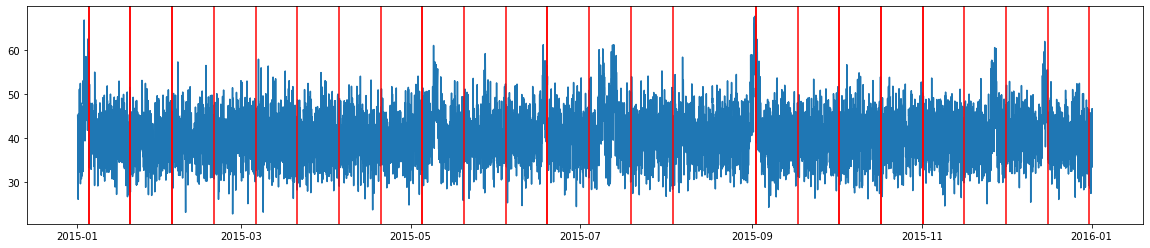

In [71]:
plt.figure(figsize=(20,4))
machineID = 1
tele = 'vibration'
plt.plot(telemetry[telemetry['machineID'] == machineID]['datetime'], telemetry[telemetry['machineID'] == machineID][tele])
for date in maint[(maint['machineID'] == machineID) & (maint['datetime'] >= pd.to_datetime('2015-01-01'))]['datetime']:
    plt.axvline(date, color = 'red', label = 'axvline - full height')

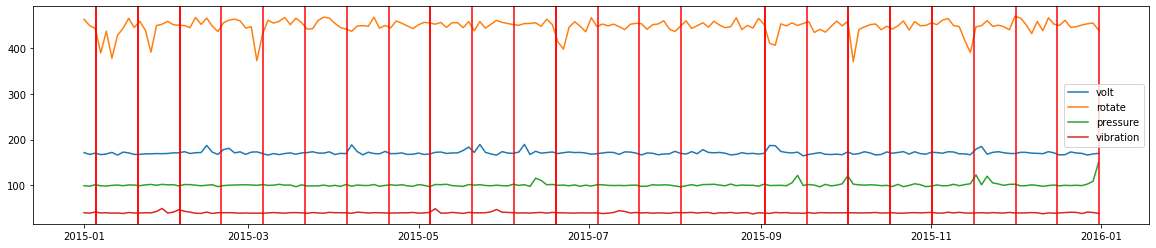

In [84]:
plt.figure(figsize=(20,4))

telemetry_week = telemetry[telemetry['machineID'] == 5].groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plt.plot(telemetry_week.index, telemetry_week['volt'])
plt.plot(telemetry_week.index, telemetry_week['rotate'])
plt.plot(telemetry_week.index, telemetry_week['pressure'])
plt.plot(telemetry_week.index, telemetry_week['vibration'])
for date in maint[(maint['machineID'] == machineID) & (maint['datetime'] >= pd.to_datetime('2015-01-01'))]['datetime']:
    plt.axvline(date, color = 'red', label = 'axvline - full height')
plt.legend(['volt', 'rotate', 'pressure', 'vibration'])

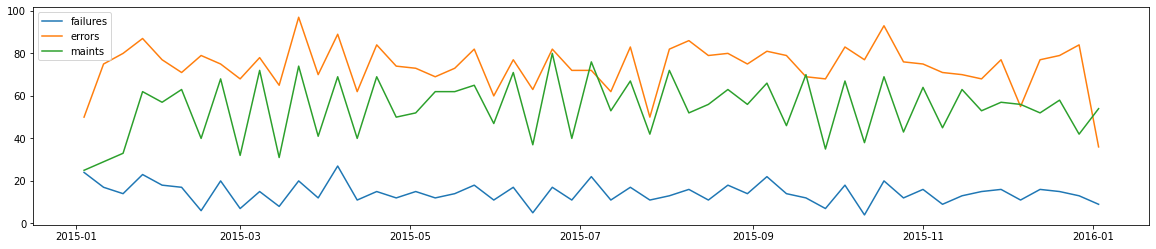

In [82]:
failures_week = failures.groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()
errors_week = errors.groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()
maint_week = maint[maint['datetime'] >= pd.to_datetime('2015-01-01')].groupby('datetime').count().groupby(pd.Grouper(freq="1W")).sum()

plt.figure(figsize=(20,4))
plt.plot(failures_week.index, failures_week['machineID'])
plt.plot(errors_week.index, errors_week['machineID'])
plt.plot(maint_week.index, maint_week['machineID'])
plt.legend(['failures', 'errors', 'maints'])

In [99]:
i_young = machines[machines['age'] == np.min(machines['age'])].index[0]
i_old = machines[machines['age'] == np.max(machines['age'])].index[0]

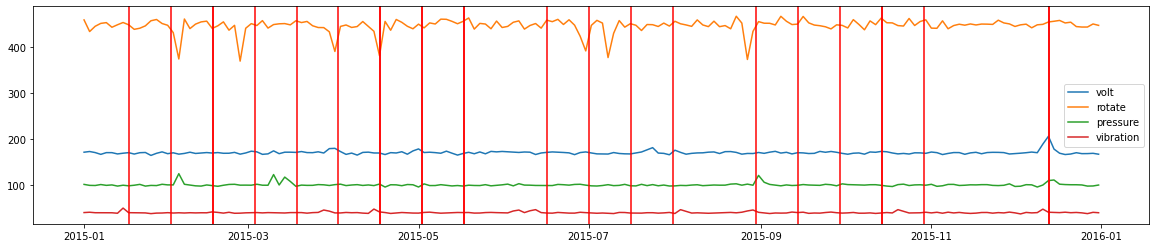

In [101]:
plt.figure(figsize=(20,4))

telemetry_week = telemetry[telemetry['machineID'] == i_young].groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plt.plot(telemetry_week.index, telemetry_week['volt'])
plt.plot(telemetry_week.index, telemetry_week['rotate'])
plt.plot(telemetry_week.index, telemetry_week['pressure'])
plt.plot(telemetry_week.index, telemetry_week['vibration'])
for date in maint[(maint['machineID'] == i_young) & (maint['datetime'] >= pd.to_datetime('2015-01-01'))]['datetime']:
    plt.axvline(date, color = 'red', label = 'axvline - full height')
plt.legend(['volt', 'rotate', 'pressure', 'vibration'])

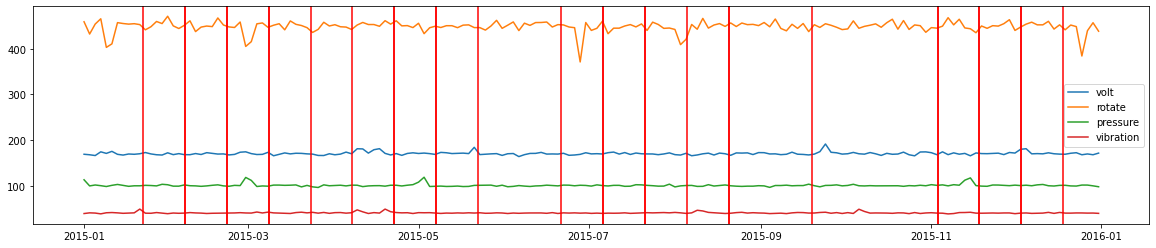

In [102]:
plt.figure(figsize=(20,4))

telemetry_week = telemetry[telemetry['machineID'] == i_old].groupby('datetime').mean().groupby(pd.Grouper(freq="2D")).mean()
plt.plot(telemetry_week.index, telemetry_week['volt'])
plt.plot(telemetry_week.index, telemetry_week['rotate'])
plt.plot(telemetry_week.index, telemetry_week['pressure'])
plt.plot(telemetry_week.index, telemetry_week['vibration'])
for date in maint[(maint['machineID'] == i_old) & (maint['datetime'] >= pd.to_datetime('2015-01-01'))]['datetime']:
    plt.axvline(date, color = 'red', label = 'axvline - full height')
plt.legend(['volt', 'rotate', 'pressure', 'vibration'])

#### ¿Qué modelo de equipamiento son los mas propensos a fallar?

Primero se necesita agrupar la información que concierne la pregunta

#### ¿Cuáles son las causas mas comunes que provocan los fallos y con que piezas se tienden a reemplazar?

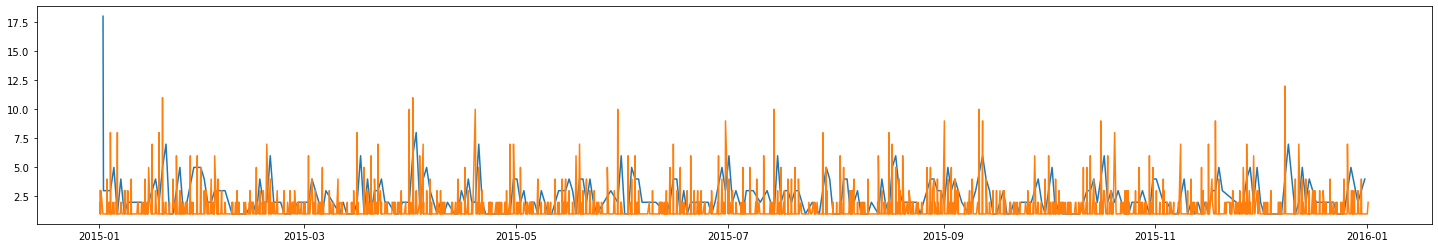

#### ¿Existe relación entre las fechas de los fallos con algun evento en especifico? Por ejemplo un apagon masivo, en cuyo caso, ¿Qué información podría proveer?

#### ¿Tendrá relación la cantidad de años en servicio y el promedio de fallos en dicho tiempo? Sera posible que a medida que más envejezca, más propenso sea a tener errores o seguira igual.

#### ¿Qué relacion existe entre las variables de telemetria? Siendo este análisis el más importante, ¿Podemos encontrar las relaciones pertinentes entre las fallas y las variables de telemetria que corresponden? ¿Cómo podríamos identificar las irregularidades para predecir que va a fallar a futuro?